# Used Car Price Prediction (CarDekho) — End-to-End ML Pipeline

This notebook builds and compares several classical machine learning models to predict used car selling prices from basic listing attributes (age/year, mileage, fuel type, transmission, seller type, ownership, and brand).

**What you'll get by the end:**
- A cleaned dataset + train/validation/test split
- Baseline + Linear / Ridge / Lasso + Random Forest + Gradient Boosting models
- A results table with MAE / RMSE / R²
- Model interpretation (top features / coefficients)
- Saved best model pipeline (`joblib`)

> Note: Many cells contain code generated with AI. Each AI-generated section is tagged with a reference like **Use of AI [3]** which maps to the `Use_of_AI.md` document.


## 0) Dataset: how to load it

This project uses the CarDekho used-car dataset (CSV) from Kaggle. The easiest workflow in Colab is:

1. Download the CSV to your computer from Kaggle.
2. In Colab, run the next cell to **upload** the CSV.
3. The notebook will automatically read it into a pandas dataframe.

If you prefer using the Kaggle API, there is an optional cell below, but uploading the CSV is simpler.


In [1]:
# The code below was generated by AI; see Use of AI [1]. Imports, settings, and helper utilities.

import io
import os
import math
import json
import joblib
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

In [2]:
# The code below was generated by AI; see Use of AI [2]. Load the dataset (recommended: upload CSV directly in Colab).

try:
    from google.colab import files  # type: ignore
    print("Colab detected. Please upload your CSV now...")
    uploaded = files.upload()  # choose the CarDekho CSV file
    filename = next(iter(uploaded))
    print(f"Loaded file: {filename}")
    df = pd.read_csv(io.BytesIO(uploaded[filename]))
except Exception as e:
    print("Colab upload not available (or upload failed).")
    print("Fallback: place the CSV in the same folder and set CSV_PATH below.")
    CSV_PATH = "CAR DETAILS FROM CAR DEKHO.csv"  # <-- update if needed
    df = pd.read_csv(CSV_PATH)

print("Shape:", df.shape)
df.head()

Colab detected. Please upload your CSV now...


Saving CAR DETAILS FROM CAR DEKHO.csv.xls to CAR DETAILS FROM CAR DEKHO.csv.xls
Loaded file: CAR DETAILS FROM CAR DEKHO.csv.xls
Shape: (4340, 8)


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


### (Optional) Kaggle API download in Colab

If you want, you can download via Kaggle API, but this requires a Kaggle account + API token (`kaggle.json`). If you're short on time, just upload the CSV and skip this.


In [3]:
# The code below was generated by AI; see Use of AI [2]. OPTIONAL Kaggle API download (only if you want it).
# Steps:
# 1) In Kaggle: Account -> Create New API Token -> downloads kaggle.json
# 2) Upload kaggle.json when prompted below
# 3) Fill in DATASET_SLUG with the dataset identifier from Kaggle (e.g., "nehalbirla/vehicle-dataset-from-cardekho")

# !pip -q install kaggle
# from google.colab import files
# files.upload()  # upload kaggle.json

# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# DATASET_SLUG = "nehalbirla/vehicle-dataset-from-cardekho"  # example
# !kaggle datasets download -d $DATASET_SLUG -p data --unzip

# df = pd.read_csv("data/CAR DETAILS FROM CAR DEKHO.csv")
# print(df.shape)
# df.head()

## 1) Quick EDA and sanity checks

We’ll quickly inspect columns, missing values, and some basic distributions. Keep this light and move on to modeling.


Columns: ['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner']


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
name,4340,1491,Maruti Swift Dzire VDI,69,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,4340.0,NaN,NaN,NaN,2013.090783,4.215344,1992.0,2011.0,2014.0,2016.0,2020.0
selling_price,4340.0,NaN,NaN,NaN,504127.311751,578548.736139,20000.0,208749.75,350000.0,600000.0,8900000.0
km_driven,4340.0,NaN,NaN,NaN,66215.777419,46644.102194,1.0,35000.0,60000.0,90000.0,806599.0
fuel,4340,5,Diesel,2153,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seller_type,4340,3,Individual,3244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
transmission,4340,2,Manual,3892,NaN,NaN,NaN,NaN,NaN,NaN,NaN
owner,4340,5,First Owner,2832,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Missing values per column:


,0
name,0
year,0
selling_price,0
km_driven,0
fuel,0
seller_type,0
transmission,0
owner,0


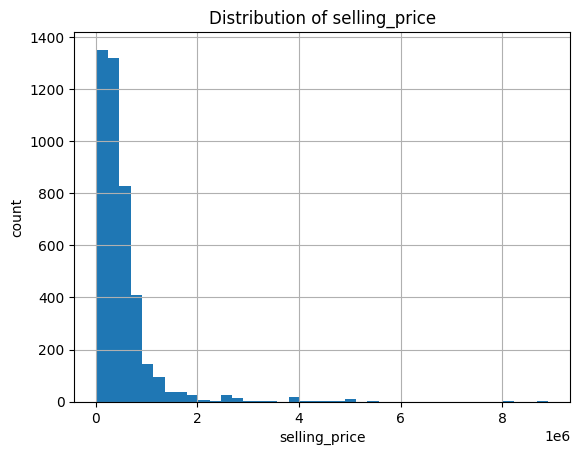

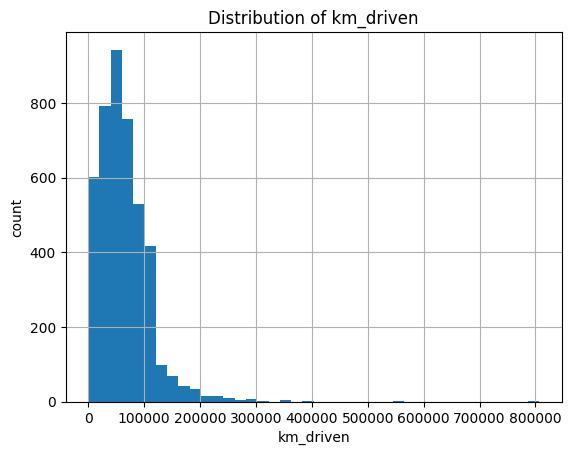

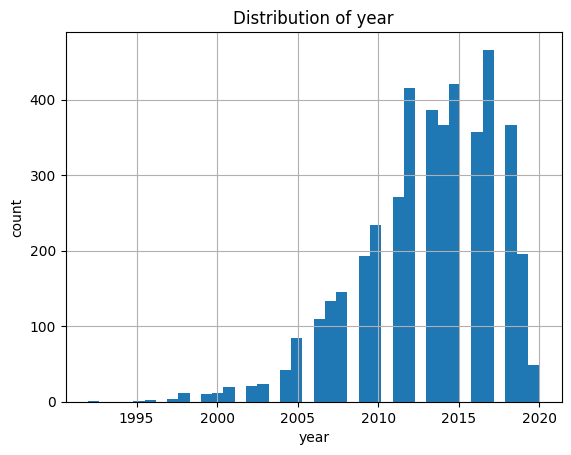

In [4]:
# The code below was generated by AI; see Use of AI [3]. Basic inspection + quick plots.

print("Columns:", list(df.columns))
display(df.describe(include="all").transpose().head(20))

print("\nMissing values per column:")
display(df.isna().sum().sort_values(ascending=False))

# Basic numeric histograms (only for columns that look numeric)
num_candidates = ["selling_price", "km_driven", "year"]
for col in [c for c in num_candidates if c in df.columns]:
    plt.figure()
    df[col].hist(bins=40)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.show()

## 2) Cleaning + feature engineering

We will:
- Ensure `selling_price` and `km_driven` are numeric
- Drop rows missing the target
- Create a `car_age` feature from `year`
- Extract a simple `brand` feature from `name`


In [13]:
# The code below was generated by AI; see Use of AI [4]. Cleaning and feature engineering.

df = df.copy()

# Standardize column names (just in case)
df.columns = [c.strip() for c in df.columns]

TARGET = "selling_price"
if TARGET not in df.columns:
    raise ValueError(f"Expected target column '{TARGET}' not found. Found columns: {df.columns.tolist()}")

def to_number(s):
    # Handles commas and stray currency symbols if present
    return pd.to_numeric(
        s.astype(str)
         .str.replace(",", "", regex=False)
         .str.replace("₹", "", regex=False)
         .str.strip(),
        errors="coerce"
    )

if "km_driven" in df.columns:
    df["km_driven"] = to_number(df["km_driven"])

df[TARGET] = to_number(df[TARGET])

# Drop rows with missing target
df = df.dropna(subset=[TARGET]).reset_index(drop=True)

# Feature: car age
if "year" in df.columns:
    current_year = datetime.now().year
    df["car_age"] = current_year - pd.to_numeric(df["year"], errors="coerce")
else:
    df["car_age"] = np.nan

# Feature: brand from name
if "name" in df.columns:
    df["brand"] = (
        df["name"].astype(str)
        .str.strip()
        .str.split()
        .str[0]
        .str.lower()
    )

# Optional: drop raw name to avoid high-cardinality one-hot explosion
DROP_COLS = [c for c in ["name"] if c in df.columns]
df = df.drop(columns=DROP_COLS)

# Drop any rows with nonsense values (light-touch)
if "km_driven" in df.columns:
    df = df[df["km_driven"].notna()]
    df = df[df["km_driven"] >= 0]

df = df[df[TARGET] > 0]

print("After cleaning:", df.shape)
df.head()

After cleaning: (4340, 9)


,year,selling_price,km_driven,fuel,seller_type,transmission,owner,car_age,brand
0,2007,60000,70000,Petrol,Individual,Manual,First Owner,18,maruti
1,2007,135000,50000,Petrol,Individual,Manual,First Owner,18,maruti
2,2012,600000,100000,Diesel,Individual,Manual,First Owner,13,hyundai
3,2017,250000,46000,Petrol,Individual,Manual,First Owner,8,datsun
4,2014,450000,141000,Diesel,Individual,Manual,Second Owner,11,honda


## 3) Train / Validation / Test split

We’ll hold out a final test set for a fair evaluation at the end.


In [6]:
# The code below was generated by AI; see Use of AI [5]. Data splitting.

X = df.drop(columns=[TARGET])
y = df[TARGET]

# 15% test, 85% temp
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, random_state=RANDOM_SEED
)

# From the remaining 85%, use ~20% as validation (so 0.85*0.20 = 17% of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.20, random_state=RANDOM_SEED
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (2951, 8) Val: (738, 8) Test: (651, 8)


## 4) Preprocessing pipeline

We’ll build a single preprocessing block that:
- imputes missing numeric values and scales them (helps linear models)
- imputes missing categorical values and one-hot encodes them


In [7]:
# The code below was generated by AI; see Use of AI [6]. Build preprocessing (ColumnTransformer) and utilities.

# Identify numeric and categorical columns automatically
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X_train.columns if c not in numeric_features]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

def make_pipeline(model):
    return Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model)
    ])

def eval_regression(model, X_tr, y_tr, X_va, y_va):
    pred_tr = model.predict(X_tr)
    pred_va = model.predict(X_va)
    return {
        "train_mae": mean_absolute_error(y_tr, pred_tr),
        "train_rmse": rmse(y_tr, pred_tr),
        "train_r2": r2_score(y_tr, pred_tr),
        "val_mae": mean_absolute_error(y_va, pred_va),
        "val_rmse": rmse(y_va, pred_va),
        "val_r2": r2_score(y_va, pred_va),
    }

Numeric features: ['year', 'km_driven', 'car_age']
Categorical features: ['fuel', 'seller_type', 'transmission', 'owner', 'brand']


## 5) Train and compare models

We will train:
- Dummy baseline (median)
- Linear Regression
- Ridge Regression (tuned)
- Lasso Regression (tuned)
- Random Forest
- Gradient Boosting

We’ll pick the best model by validation MAE (lower is better), then do a final evaluation on the test set.


In [8]:
# The code below was generated by AI; see Use of AI [7]. Train models + collect results.

results = []

def add_result(name, model, metrics):
    row = {"model": name}
    row.update(metrics)
    results.append(row)

# 1) Baseline
baseline = make_pipeline(DummyRegressor(strategy="median"))
baseline.fit(X_train, y_train)
add_result("DummyRegressor(median)", baseline, eval_regression(baseline, X_train, y_train, X_val, y_val))

# 2) Linear Regression
lin = make_pipeline(LinearRegression())
lin.fit(X_train, y_train)
add_result("LinearRegression", lin, eval_regression(lin, X_train, y_train, X_val, y_val))

# 3) Ridge (tune alpha)
ridge = make_pipeline(Ridge(random_state=RANDOM_SEED))
ridge_params = {"model__alpha": np.logspace(-2, 3, 10)}
ridge_search = GridSearchCV(ridge, ridge_params, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
ridge_search.fit(X_train, y_train)
best_ridge = ridge_search.best_estimator_
add_result(f"Ridge(best alpha={ridge_search.best_params_['model__alpha']:.4g})",
           best_ridge, eval_regression(best_ridge, X_train, y_train, X_val, y_val))

# 4) Lasso (tune alpha)
lasso = make_pipeline(Lasso(max_iter=20000, random_state=RANDOM_SEED))
lasso_params = {"model__alpha": np.logspace(-3, 1, 10)}
lasso_search = GridSearchCV(lasso, lasso_params, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
lasso_search.fit(X_train, y_train)
best_lasso = lasso_search.best_estimator_
add_result(f"Lasso(best alpha={lasso_search.best_params_['model__alpha']:.4g})",
           best_lasso, eval_regression(best_lasso, X_train, y_train, X_val, y_val))

# 5) Random Forest (light tuning-free default)
rf = make_pipeline(RandomForestRegressor(
    n_estimators=400,
    random_state=RANDOM_SEED,
    n_jobs=-1
))
rf.fit(X_train, y_train)
add_result("RandomForest(n=400)", rf, eval_regression(rf, X_train, y_train, X_val, y_val))

# 6) Gradient Boosting
gbr = make_pipeline(GradientBoostingRegressor(random_state=RANDOM_SEED))
gbr.fit(X_train, y_train)
add_result("GradientBoostingRegressor", gbr, eval_regression(gbr, X_train, y_train, X_val, y_val))

results_df = pd.DataFrame(results).sort_values("val_mae")
results_df

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39881445139736.16, tolerance: 112185981335.0378
  model = cd_fast.sparse_enet_coordinate_descent(


,model,train_mae,train_rmse,train_r2,val_mae,val_rmse,val_r2
4,RandomForest(n=400),53328.026893,107967.900122,0.969337,111816.819278,203013.767941,0.832904
5,GradientBoostingRegressor,130997.293830,201838.364592,0.892839,137394.570330,208309.339156,0.824072
1,LinearRegression,181667.462399,337578.956227,0.700235,175779.544444,294815.509359,0.647615
2,Ridge(best alpha=0.01),181690.409585,337579.606170,0.700234,175783.285955,294795.609888,0.647663
3,Lasso(best alpha=0.001),181666.011912,337578.953734,0.700235,176967.612277,297574.912777,0.640988
0,DummyRegressor(median),311946.492714,635949.358040,-0.063838,285855.017615,511669.909711,-0.061442


## 6) Select best model and evaluate on the test set

We’ll refit the best model on **train + validation** and report final test performance.


In [9]:
# The code below was generated by AI; see Use of AI [8]. Refit best model and test evaluation.

# Identify best model by validation MAE
best_name = results_df.iloc[0]["model"]
print("Best (by val MAE):", best_name)

# Map names to trained estimators
trained_models = {
    "DummyRegressor(median)": baseline,
    "LinearRegression": lin,
    [r["model"] for r in results if r["model"].startswith("Ridge(")][0]: best_ridge,
    [r["model"] for r in results if r["model"].startswith("Lasso(")][0]: best_lasso,
    "RandomForest(n=400)": rf,
    "GradientBoostingRegressor": gbr
}
best_model = trained_models[best_name]

# Refit on train+val
X_tr_full = pd.concat([X_train, X_val], axis=0)
y_tr_full = pd.concat([y_train, y_val], axis=0)

best_model.fit(X_tr_full, y_tr_full)

test_pred = best_model.predict(X_test)

test_mae = mean_absolute_error(y_test, test_pred)
test_rmse = rmse(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

print(f"Test MAE : {test_mae:,.2f}")
print(f"Test RMSE: {test_rmse:,.2f}")
print(f"Test R^2 : {test_r2:.4f}")

Best (by val MAE): RandomForest(n=400)
Test MAE : 104,255.22
Test RMSE: 171,943.40
Test R^2 : 0.8692


## 7) Diagnostic plots

These plots help you understand how the model behaves and where it makes errors.


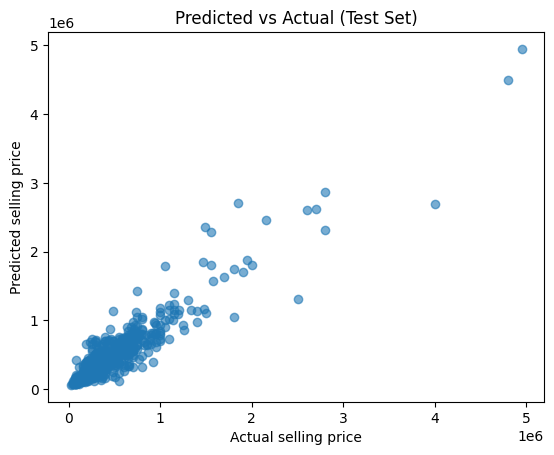

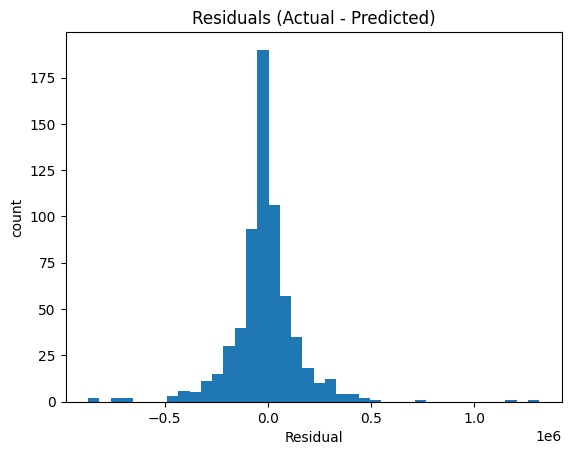

In [10]:
# The code below was generated by AI; see Use of AI [9]. Predicted vs actual + residuals.

plt.figure()
plt.scatter(y_test, test_pred, alpha=0.6)
plt.title("Predicted vs Actual (Test Set)")
plt.xlabel("Actual selling price")
plt.ylabel("Predicted selling price")
plt.show()

residuals = (y_test - test_pred)

plt.figure()
plt.hist(residuals, bins=40)
plt.title("Residuals (Actual - Predicted)")
plt.xlabel("Residual")
plt.ylabel("count")
plt.show()

## 8) Model interpretation (top features)

We’ll extract the feature names after one-hot encoding and show the top coefficients or importances (depending on the best model type).


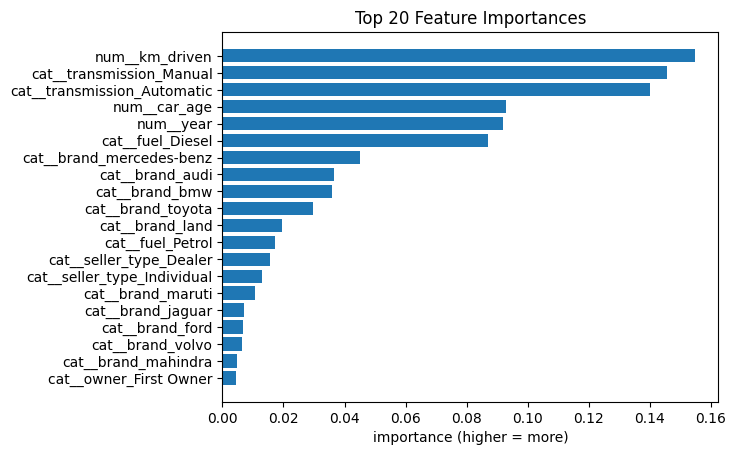

In [11]:
# The code below was generated by AI; see Use of AI [10]. Feature importance / coefficients extraction.

def get_feature_names_from_preprocess(preprocess_obj):
    # Works for scikit-learn >= 1.0
    try:
        return preprocess_obj.get_feature_names_out()
    except Exception:
        # fallback: return indices
        return None

pre = best_model.named_steps["preprocess"]
model = best_model.named_steps["model"]
feature_names = get_feature_names_from_preprocess(pre)

def show_top_features(importances, feature_names, top_n=20, title="Top features"):
    if feature_names is None:
        # fallback: just show numeric indices
        feature_names = np.array([f"f{i}" for i in range(len(importances))])
    else:
        feature_names = np.array(feature_names)

    order = np.argsort(importances)[::-1][:top_n]
    top_feats = feature_names[order]
    top_vals = importances[order]

    plt.figure()
    plt.barh(list(reversed(top_feats)), list(reversed(top_vals)))
    plt.title(title)
    plt.xlabel("importance (higher = more)")
    plt.show()

if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
    show_top_features(importances, feature_names, top_n=20, title="Top 20 Feature Importances")
elif hasattr(model, "coef_"):
    coefs = model.coef_
    # Show by absolute magnitude
    order = np.argsort(np.abs(coefs))[::-1][:20]
    display(pd.DataFrame({
        "feature": (feature_names[order] if feature_names is not None else order),
        "coef": coefs[order],
        "abs_coef": np.abs(coefs[order])
    }).sort_values("abs_coef", ascending=False))
else:
    print("This model type does not expose feature_importances_ or coef_.")

## 9) Save the trained model

This saves the *full pipeline* (preprocessing + model). You can load it later and call `.predict()` on raw feature rows.


In [12]:
# The code below was generated by AI; see Use of AI [11]. Save pipeline with joblib.

MODEL_PATH = "best_used_car_price_model.joblib"
joblib.dump(best_model, MODEL_PATH)
print("Saved:", MODEL_PATH)

# Example: load and predict on the first 5 rows of the test set
loaded = joblib.load(MODEL_PATH)
loaded.predict(X_test.head())

Saved: best_used_car_price_model.joblib


array([ 153683.98809524,  355889.58333333,  130177.91666667,
        430088.69047619, 1127393.335     ])